In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [93]:
df_2018 = pd.read_excel("nba_2018_19.xlsx")
df_2019 = pd.read_excel("nba_2019_20.xlsx")
df_2020 = pd.read_excel("nba_2020_21.xlsx")
df_2021 = pd.read_excel("nba_2021_22.xlsx")
df_2022 = pd.read_excel('nba_2022_23.xlsx')

df_2022['AST/TOV'] = df_2022['AST'] / df_2022['TOV']
df_2021['AST/TOV'] = df_2021['AST'] / df_2021['TOV']
df_2020['AST/TOV'] = df_2020['AST'] / df_2020['TOV']
df_2019['AST/TOV'] = df_2019['AST'] / df_2019['TOV']
df_2018['AST/TOV'] = df_2018['AST'] / df_2018['TOV']

df_2022['Corner 3-pt Per Game'] = df_2022['3PA'] * df_2022['CORNER FREQ'] * df_2022['CORNER RATE']
df_2021['Corner 3-pt Per Game'] = df_2021['3PA'] * df_2021['CORNER FREQ'] * df_2021['CORNER RATE']
df_2020['Corner 3-pt Per Game'] = df_2020['3PA'] * df_2020['CORNER FREQ'] * df_2020['CORNER RATE']
df_2019['Corner 3-pt Per Game'] = df_2019['3PA'] * df_2019['CORNER FREQ'] * df_2019['CORNER RATE']
df_2018['Corner 3-pt Per Game'] = df_2018['3PA'] * df_2018['CORNER FREQ'] * df_2018['CORNER RATE']

In [3]:
# Use this color dictionary for all graphs to differentiate based on each team's playoff status

colors = {'Missed Playoffs' : 'brown', 'Made Playoffs' : 'blue', 'Made Final Four' : 'green', 'Won Finals' : 'red'}

In [4]:
# Function to make scatterplot and generate regression line and r^2 value given dataframe and statistic column

def test_statistic(df, stat, figsize = (8, 5), y = "W", playoffs = "PLAYOFFS", s = 50, 
                   title = 'Default', xlabel = 'Default', ylabel = 'Default'):
    
    if title == 'Default':
        title = f'{stat} effect on Wins'
    if xlabel == 'Default':
        xlabel = stat
    if ylabel == 'Default':
        ylabel = 'Wins'
    
    plt.figure(figsize = figsize)
    scatter = sns.scatterplot(x = stat, y = y, data = df, hue = playoffs, palette = colors, s = s)
    scatter.set(title = title, xlabel = xlabel, ylabel = ylabel)
    
    x = df[stat].values.reshape(-1, 1)
    y = df[y].values
    model = LinearRegression().fit(x, y)
    plt.plot(x, model.predict(x), color = 'black', alpha = 0.6)
    r_2 = r2_score(y, model.predict(x))
    
    plt.show()
    
    print(f'R-squared: {r_2}')

Our model will consist of the following weights:
* 70%: Net rating (ORTG - DRTG)
* 13%: Defensive EFG%
* 11%: 3-point FG%
* 4%: AST/TO Rate
* 2%: Corner 3-point Per Game


**Part 1: EDA on 2021-22 season**

In [39]:
model_parameters = pd.DataFrame(columns = ["Team", "Wins", 'Playoffs', "Net Rating", 
                                           "Defensive EFG%", '3-pt FG%', 
                                           'AST/TO Rate', 'Corner 3-pt Per Game'])
model_parameters['Team'] = df_2021['TEAM']
model_parameters['Wins'] = df_2021['W']
model_parameters['Playoffs'] = df_2021['PLAYOFFS']

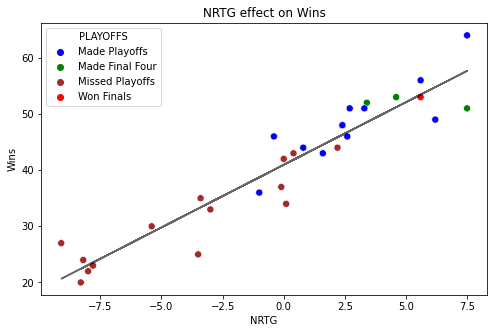

R-squared: 0.8946227362831126


In [40]:
# Net Rating

df_2021['NRTG'] = df_2021['ORTG'] - df_2021['DRTG']

test_statistic(df_2021, 'NRTG')

In [67]:
# Turn into percentiles

model_parameters["Net Rating"] = np.round(((df_2021['NRTG'] + 12.5) / 25) * 70, 2)

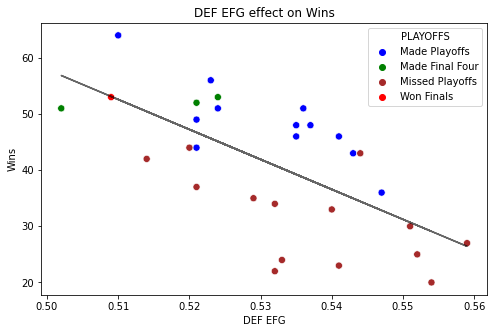

R-squared: 0.42811115977657477


In [42]:
# Defensive EFG%

test_statistic(df_2021, 'DEF EFG')

In [68]:
model_parameters["Defensive EFG%"] = np.round(((1 - (df_2021['DEF EFG'] - 0.50) / 0.06) * 13), 2)

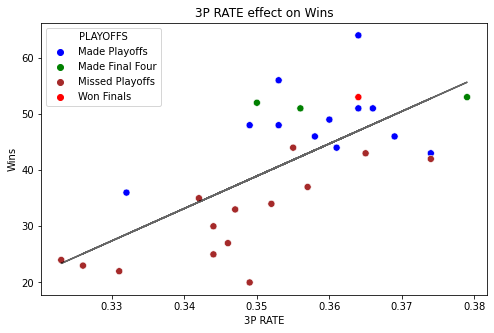

R-squared: 0.48007715010468777


In [44]:
# 3-pt FG

test_statistic(df_2021, '3P RATE')

In [69]:
model_parameters['3-pt FG%'] = np.round(((df_2021['3P RATE'] - 0.31) / 0.07), 2) * 11

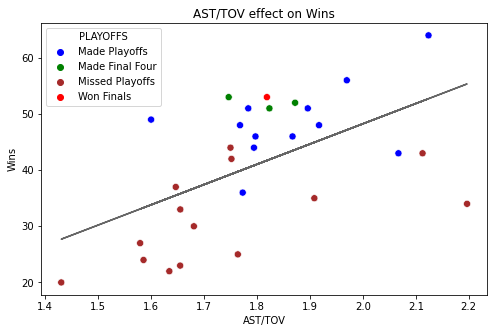

R-squared: 0.30012218167053795


In [46]:
# AST/TO Rate
df_2021['AST/TOV'] = df_2021['AST'] / df_2021['TOV']

test_statistic(df_2021, 'AST/TOV')

In [70]:
model_parameters['AST/TO Rate'] = np.round(((df_2021['AST/TOV'] - 1.5) / 0.6), 2) * 4

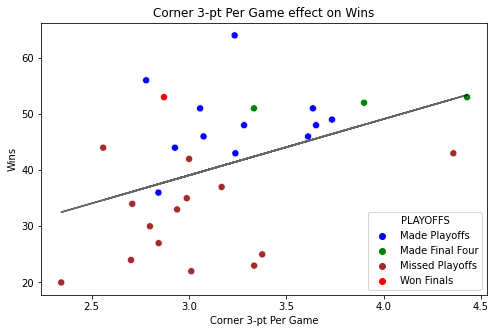

R-squared: 0.1782088292217352


In [48]:
# Corner 3-pt Per Game

test_statistic(df_2021, 'Corner 3-pt Per Game')

In [71]:
model_parameters['Corner 3-pt Per Game'] = np.round(((df_2021['Corner 3-pt Per Game'] - 2.5) / 1.5), 2) * 2

In [72]:
model_parameters['Score'] = model_parameters[['Net Rating', 'Defensive EFG%', 
                                              '3-pt FG%', 'AST/TO Rate', 
                                              'Corner 3-pt Per Game']].sum(axis = 1) * 0.82

In [84]:
df1 = model_parameters[['Team', 'Wins', 'Playoffs']].sort_values(by = 'Wins', ascending = False).reset_index(drop = True)
df2 = model_parameters[['Team', 'Score', 'Playoffs']].sort_values(by = 'Score', ascending = False).reset_index(drop = True)

results = pd.concat([df1, df2], axis = 1)
results[['Wins', 'Team', 'Score']]

,Wins,Team,Team,Score
0,64,Phoenix Suns,Phoenix Suns,65.9608
1,56,Memphis Grizzlies,Boston Celtics,64.8702
2,53,Miami Heat,Golden State Warriors,59.7124
3,53,Golden State Warriors,Utah Jazz,58.1708
4,52,Dallas Mavericks,Miami Heat,58.0478
5,51,Boston Celtics,Memphis Grizzlies,56.5062
6,51,Philadelphia 76ers,Dallas Mavericks,52.1356
7,51,Milwaukee Bucks,Philadelphia 76ers,51.0122
8,49,Utah Jazz,Milwaukee Bucks,50.5448
9,48,Denver Nuggets,Minnesota Timberwolves,48.1914


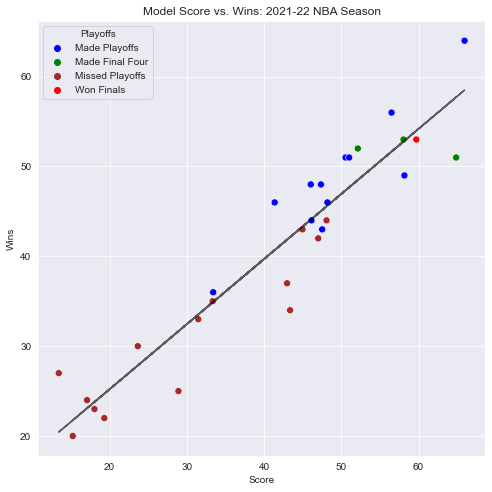

R-squared: 0.894503871749798


In [77]:
sns.set_style('darkgrid')
test_statistic(df = model_parameters, stat = 'Score', y = "Wins", playoffs = "Playoffs", figsize = (8, 8),
              title = "Model Score vs. Wins: 2021-22 NBA Season")

In [87]:
def score_model(df, year):
    model_parameters = pd.DataFrame(columns = ["Team", "Wins", 'Playoffs', "Net Rating", 
                                               "Defensive EFG%", '3-pt FG%', 
                                               'AST/TO Rate', 'Corner 3-pt Per Game'])
    model_parameters['Team'] = df['Team']
    model_parameters['Wins'] = df['W']
    model_parameters['Playoffs'] = df['PLAYOFFS']
    
    model_parameters["Net Rating"] = np.round(((df['NRTG'] + 12.5) / 25) * 70, 2)
    model_parameters["Defensive EFG%"] = np.round(((1 - (df['DEF EFG'] - 0.50) / 0.06) * 13), 2)
    model_parameters['3-pt FG%'] = np.round(((df['3P RATE'] - 0.31) / 0.07), 2) * 11
    model_parameters['AST/TO Rate'] = np.round(((df['AST/TOV'] - 1.5) / 0.6), 2) * 4
    model_parameters['Corner 3-pt Per Game'] = np.round(((df['Corner 3-pt Per Game'] - 2.5) / 1.5), 2) * 2\
    
    model_parameters['Score'] = model_parameters[['Net Rating', 'Defensive EFG%', 
                                                  '3-pt FG%', 'AST/TO Rate', 
                                                  'Corner 3-pt Per Game']].sum(axis = 1) * 0.82
    df1 = model_parameters[['Team', 'Wins', 'Playoffs']].sort_values(by = 'Wins', ascending = False).reset_index(drop = True)
    df2 = model_parameters[['Team', 'Score', 'Playoffs']].sort_values(by = 'Score', ascending = False).reset_index(drop = True)

    results = pd.concat([df1, df2], axis = 1)
    sns.set_style('darkgrid')
    test_statistic(df = model_parameters, stat = 'Score', y = "Wins", playoffs = "Playoffs", figsize = (8, 8),
              title = f"Model Score vs. Wins: {year} NBA Season")
    return results[['Wins', 'Team', 'Score']]


In [103]:
def score_model_incomplete_data(df, year):
    model_parameters = pd.DataFrame(columns = ["Team", "Net Rating", 
                                               "Defensive EFG%", '3-pt FG%', 
                                               'AST/TO Rate', 'Corner 3-pt Per Game'])
    model_parameters['Team'] = df['Team']
    
    model_parameters["Net Rating"] = np.round(((df['NRTG'] + 12.5) / 25) * 70, 2)
    model_parameters["Defensive EFG%"] = np.round(((1 - (df['DEF EFG'] - 0.50) / 0.06) * 13), 2)
    model_parameters['3-pt FG%'] = np.round(((df['3P RATE'] - 0.31) / 0.07), 2) * 11
    model_parameters['AST/TO Rate'] = np.round(((df['AST/TOV'] - 1.5) / 0.6), 2) * 4
    model_parameters['Corner 3-pt Per Game'] = np.round(((df['Corner 3-pt Per Game'] - 2.5) / 1.5), 2) * 2\
    
    model_parameters['Score'] = model_parameters[['Net Rating', 'Defensive EFG%', 
                                                  '3-pt FG%', 'AST/TO Rate', 
                                                  'Corner 3-pt Per Game']].sum(axis = 1) * 0.82
    
    return model_parameters[['Team', 'Score']].sort_values(by = 'Score', ascending = False)

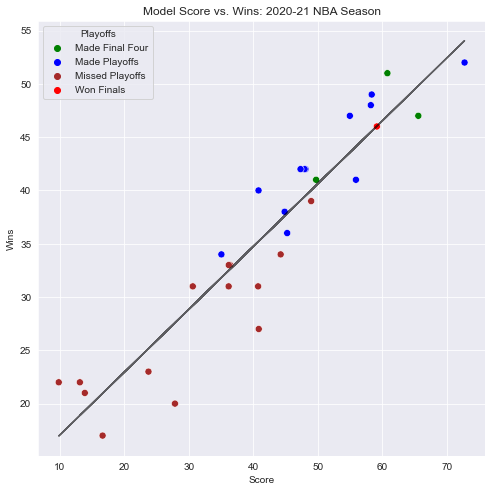

R-squared: 0.8833750678771104


,Wins,Team,Team,Score
0,52,Utah Jazz*,Utah Jazz*,72.7094
1,51,Phoenix Suns*,Los Angeles Clippers*,65.5508
2,49,Philadelphia 76ers*,Phoenix Suns*,60.7620
3,48,Brooklyn Nets*,Milwaukee Bucks*,59.1302
4,47,Los Angeles Clippers*,Philadelphia 76ers*,58.3348
5,47,Denver Nuggets*,Brooklyn Nets*,58.1954
6,46,Milwaukee Bucks*,New York Knicks*,55.8912
7,42,Portland Trail Blazers*,Denver Nuggets*,54.9482
8,42,Dallas Mavericks*,Atlanta Hawks*,49.7248
9,42,Los Angeles Lakers*,Golden State Warriors,48.9622


In [88]:
score_model(df_2020, '2020-21')

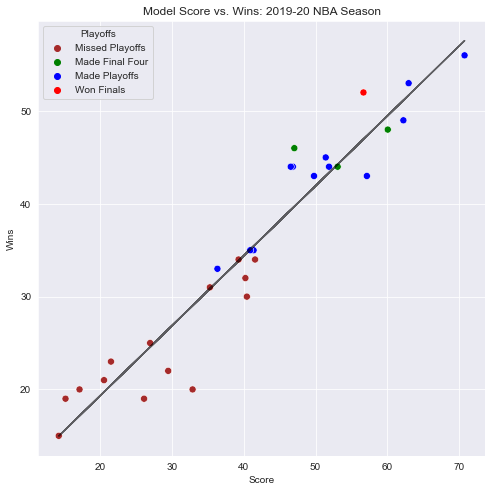

R-squared: 0.9200875384236136


,Wins,Team,Team,Score
0,56,Milwaukee Bucks*,Milwaukee Bucks*,70.7496
1,53,Toronto Raptors*,Toronto Raptors*,62.9596
2,52,Los Angeles Lakers*,Los Angeles Clippers*,62.2298
3,49,Los Angeles Clippers*,Boston Celtics*,60.0568
4,48,Boston Celtics*,Dallas Mavericks*,57.1458
5,46,Denver Nuggets*,Los Angeles Lakers*,56.6702
6,45,Indiana Pacers*,Miami Heat*,53.0786
7,44,Miami Heat*,Utah Jazz*,51.8732
8,44,Houston Rockets*,Indiana Pacers*,51.4140
9,44,Utah Jazz*,Philadelphia 76ers*,49.7822


In [89]:
score_model(df_2019, '2019-20')

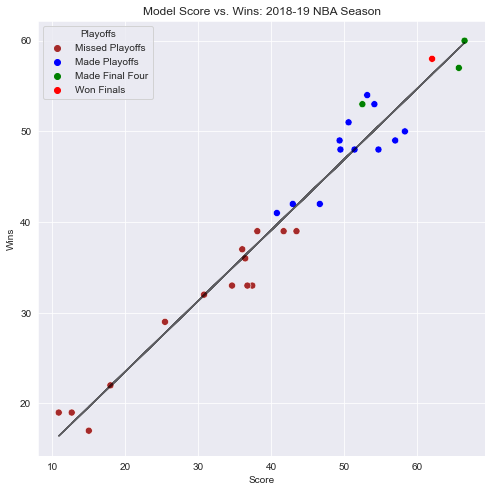

R-squared: 0.9580910796022633


,Wins,Team,Team,Score
0,60,Milwaukee Bucks*,Milwaukee Bucks*,66.5184
1,58,Toronto Raptors*,Golden State Warriors*,65.7312
2,57,Golden State Warriors*,Toronto Raptors*,62.0658
3,54,Denver Nuggets*,Utah Jazz*,58.3348
4,53,Houston Rockets*,Boston Celtics*,57.0064
5,53,Portland Trail Blazers*,Indiana Pacers*,54.7104
6,51,Philadelphia 76ers*,Houston Rockets*,54.1528
7,50,Utah Jazz*,Denver Nuggets*,53.1688
8,49,Oklahoma City Thunder*,Portland Trail Blazers*,52.5046
9,49,Boston Celtics*,San Antonio Spurs*,51.4304


In [90]:
score_model(df_2018, '2018-19')

In [104]:
score_model_incomplete_data(df_2022, '2022-23 season')

,Team,Score
1,Boston Celtics,65.9034
23,Phoenix Suns,64.3126
5,Cleveland Cavaliers,60.7374
18,New Orleans Pelicans,55.9568
16,Milwaukee Bucks,54.2922
22,Philadelphia 76ers,53.5050
2,Brooklyn Nets,48.2652
28,Utah Jazz,46.3710
9,Golden State Warriors,45.4608
11,Indiana Pacers,44.3866
